In [1]:
'''
File to build torch sciplex dataset
'''

import anndata as ad
import scipy
import pandas as pd
import os
import sys
import os.path as osp
import networkx as nx

# Core scverse libraries
import scanpy as sc
import anndata as ad
import scrublet as scr

import matplotlib.pyplot as plt
import scanpy as sc
import numpy as np

sys.path.append('../rep-learning-approach-3-all-genes')
from export_data_for_torch_geometric import load_ppi #imports these functions from previously-used scripts for consistency





binarization = 'real_lognorm'
outdir = '../../processed/sciplex/{}/'.format(binarization)
os.makedirs(outdir, exist_ok=True)
log_handle = open(osp.join(outdir, 'log_export_data.txt'), 'w')

/data/ggg17/anaconda3_new/envs/pdgrapher/lib/python3.8/site-packages/torch_geometric/typing.py:101: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: libcusparse.so.11: cannot open shared object file: No such file or directory
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


### Loading data and selecting a cell line

In [2]:
cell_line = 'MCF7'

############################
#Loads diseased, and treated data
obs_and_int = ad.read_h5ad('../../processed/sciplex/data/SrivatsanTrapnell2020_sciplex3_preprocessed_{}.h5ad'.format(cell_line))
obs_and_int = obs_and_int[~obs_and_int.obs.cell_line.isna()]
# cell_line = 'K562', 'A549', 'MCF7'

############################
#Selects a single cell line to proceed with data filtering/processing
data = obs_and_int[obs_and_int.obs.cell_line == cell_line]

############################
#Keeps only human genes
print(f"Before filtering, dataset contains {data.n_vars} genes and {data.n_obs} cells.")

is_human_gene = data.var['ensembl_id'].str.startswith('ENSG')
data_human_only = data[:, is_human_gene]

# Check how many genes and cells are left after filtering
print(f"After filtering, dataset contains {data_human_only.n_vars} genes and {data_human_only.n_obs} cells.")

data = data_human_only


Before filtering, dataset contains 110984 genes and 344862 cells.
After filtering, dataset contains 58347 genes and 344862 cells.


### Single-cell data processing

In [3]:
############################
#Single-cell data processing

#Quality control
sc.pp.calculate_qc_metrics(
    data, inplace=True, log1p=True
)


/data/ggg17/anaconda3_new/envs/pdgrapher/lib/python3.8/site-packages/scanpy/preprocessing/_qc.py:135: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[obs_metrics.columns] = obs_metrics


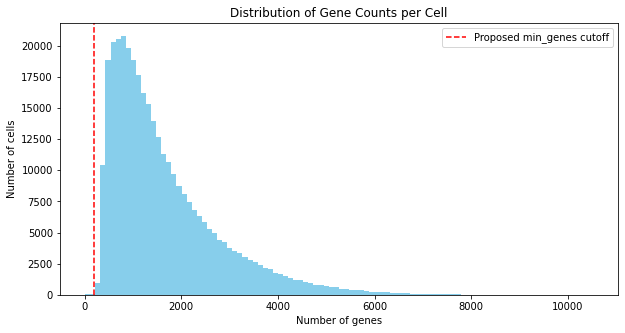

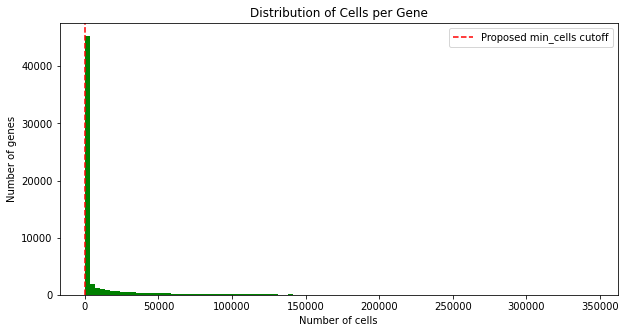

In [4]:
proposed_min_genes_cutoff = 200
proposed_min_cells_cutoff = 10

# Calculate quality control metrics if not already done
sc.pp.calculate_qc_metrics(data, inplace=True)

# Plot the distribution of gene counts per cell
plt.figure(figsize=(10, 5))
plt.hist(data.obs['n_genes_by_counts'], bins=100, color='skyblue')
plt.title('Distribution of Gene Counts per Cell')
plt.xlabel('Number of genes')
plt.ylabel('Number of cells')
plt.axvline(x=proposed_min_genes_cutoff, color='red', linestyle='--', label='Proposed min_genes cutoff')
plt.legend()
plt.show()

# Plot the distribution of cells per gene
plt.figure(figsize=(10, 5))
plt.hist(data.var['n_cells_by_counts'], bins=100, color='green')
plt.title('Distribution of Cells per Gene')
plt.xlabel('Number of cells')
plt.ylabel('Number of genes')
plt.axvline(x=proposed_min_cells_cutoff, color='red', linestyle='--', label='Proposed min_cells cutoff')
plt.legend()
plt.show()


In [5]:
#filter cells
print(f'Filtering to keep only cells with {proposed_min_genes_cutoff} expressed genes')
print(f"Before filtering, dataset contains {data.n_vars} genes and {data.n_obs} cells.")
sc.pp.filter_cells(data, min_genes=proposed_min_genes_cutoff)
print(f"Before filtering, dataset contains {data.n_vars} genes and {data.n_obs} cells.")

print('\n------\n')
print(f'Filtering to keep only genes expressed in at least {proposed_min_cells_cutoff} cells')
print(f"Before filtering, dataset contains {data.n_vars} genes and {data.n_obs} cells.")
sc.pp.filter_genes(data, min_cells=proposed_min_cells_cutoff)
print(f"After filtering, dataset contains {data.n_vars} genes and {data.n_obs} cells.")

Filtering to keep only cells with 200 expressed genes
Before filtering, dataset contains 58347 genes and 344862 cells.
Before filtering, dataset contains 58347 genes and 344764 cells.

------

Filtering to keep only genes expressed in at least 10 cells
Before filtering, dataset contains 58347 genes and 344764 cells.
After filtering, dataset contains 35734 genes and 344764 cells.


In [6]:
# #doublet detection - filters out cells identified as doublets
# print(f"Before filtering, dataset contains {data.n_vars} genes and {data.n_obs} cells.")

# scrub = scr.Scrublet(data.X)  # Create a Scrublet object
# doublet_scores, predicted_doublets = scrub.scrub_doublets()
# data.obs['doublet_scores'] = doublet_scores
# data.obs['predicted_doublets'] = predicted_doublets
# data = data[data.obs['predicted_doublets'] == False]

# print(f"After filtering, dataset contains {data.n_vars} genes and {data.n_obs} cells.")



In [7]:
# Recalculate QC metrics post-doublet removal
sc.pp.calculate_qc_metrics(
    data, inplace=True, log1p=True
)

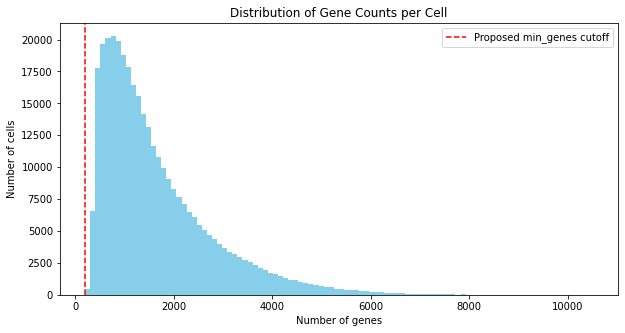

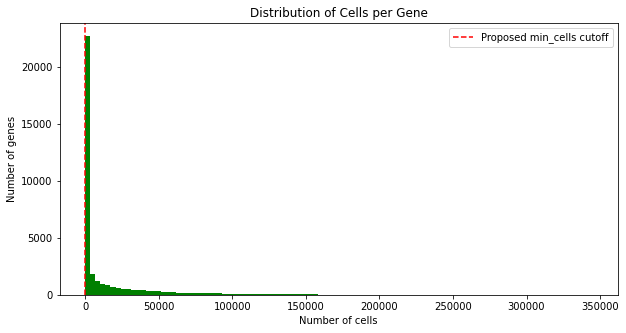

In [8]:
proposed_min_genes_cutoff = 200
proposed_min_cells_cutoff = 10

# Calculate quality control metrics if not already done
sc.pp.calculate_qc_metrics(data, inplace=True)

# Plot the distribution of gene counts per cell
plt.figure(figsize=(10, 5))
plt.hist(data.obs['n_genes_by_counts'], bins=100, color='skyblue')
plt.title('Distribution of Gene Counts per Cell')
plt.xlabel('Number of genes')
plt.ylabel('Number of cells')
plt.axvline(x=proposed_min_genes_cutoff, color='red', linestyle='--', label='Proposed min_genes cutoff')
plt.legend()
plt.show()

# Plot the distribution of cells per gene
plt.figure(figsize=(10, 5))
plt.hist(data.var['n_cells_by_counts'], bins=100, color='green')
plt.title('Distribution of Cells per Gene')
plt.xlabel('Number of cells')
plt.ylabel('Number of genes')
plt.axvline(x=proposed_min_cells_cutoff, color='red', linestyle='--', label='Proposed min_cells cutoff')
plt.legend()
plt.show()


In [9]:
#normalization
data.layers["counts"] = data.X.copy() # Saving count data
sc.pp.normalize_total(data)    # Normalizing to median total counts
sc.pp.log1p(data)      # Logarithmize the data

In [10]:
data

AnnData object with n_obs × n_vars = 344764 × 35734
    obs: 'ncounts', 'well', 'plate', 'cell_line', 'replicate', 'time', 'dose_value', 'pathway_level_1', 'pathway_level_2', 'perturbation', 'target', 'pathway', 'dose_unit', 'celltype', 'disease', 'cancer', 'tissue_type', 'organism', 'perturbation_type', 'ngenes', 'percent_mito', 'percent_ribo', 'nperts', 'chembl-ID', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'n_genes'
    var: 'ensembl_id', 'ncounts', 'ncells', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells'
    uns: 'log1p'
    layers: 'counts'

In [11]:
#Selecting highly-variable genes (to remove overwhelming presence of zeros)
hvg_cutoff = 5000
print(f'Filtering to keep only top {hvg_cutoff} highly-variable genes')
print(f"Before filtering, dataset contains {data.n_vars} genes and {data.n_obs} cells.")
sc.pp.highly_variable_genes(data, n_top_genes=hvg_cutoff, batch_key="plate")
data = data[:, data.var['highly_variable']]
print(f"After filtering, dataset contains {data.n_vars} genes and {data.n_obs} cells.")

Filtering to keep only top 5000 highly-variable genes
Before filtering, dataset contains 35734 genes and 344764 cells.


/data/ggg17/anaconda3_new/envs/pdgrapher/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/data/ggg17/anaconda3_new/envs/pdgrapher/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/data/ggg17/anaconda3_new/envs/pdgrapher/lib/python3.8/site-packages/scanpy/preprocessing/_highly_variable_genes.py:478: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  hvg = hvg.append(missing_hvg, ignore_index=True)
/data/ggg17/anaconda3_new/envs/pdgrapher/lib/python3.8/site-packages/scanpy/preproces

After filtering, dataset contains 5000 genes and 344764 cells.


### Mapping gene names to PPI and filtering

In [12]:


#Rename gene names in sciplex from ensenmbl to gene symbols
gene_conversion_info = pd.read_csv('../../raw/ppi/2022-03-PPI/data/hgnc2map.txt', sep = '\t')
dict_conversion = dict(zip(gene_conversion_info['Ensembl gene ID'], gene_conversion_info['Approved symbol']))

has_mapping = [e in dict_conversion for e in data.var.ensembl_id.tolist()]
data = data[:, has_mapping]



#Loads existing PPI, filter genes in sciplex to only keep those in the PPI, get the genes and ordering
#PPI
ppi = load_ppi('../../processed/ppi/ppi_all_genes_edgelist.txt', log_handle)
gene_symbols_in_ppi = list(ppi.nodes())


    #filters genes in sciplex to keep only those in the ppi
is_in_ppi = [dict_conversion[e] in gene_symbols_in_ppi for e in data.var.ensembl_id.tolist()]
data = data[:, is_in_ppi]


#Obtains sciplex dataframe
X = pd.DataFrame(data=data.X.todense() if isinstance(data.X, scipy.sparse.spmatrix) else data.X, 
                       index=data.obs.perturbation,  # Cell identifiers
                       columns=data.var.ensembl_id)  # Gene identifiers

symbol_columns = [dict_conversion[e] for e in X.columns]
X.columns = symbol_columns      #Adds gene symbols as column names

### Mapping drug names to DrugBank

In [13]:
'''
This code block reads DrugBank data to create a dataframe with information to faciliate mapping between perturbagen names in sciplex and drugbank
'''

######################
#DRUG TARGETS - Reads in drugbank XML to find all sysnonyms of a drug

import xml.etree.ElementTree as ET
import collections

###Load DrugBank Data
DATAROOT= '../../raw/drugbank/2022-11-DrugBank/data/'
xml_path = os.path.join(DATAROOT, 'all-full-database.xml')
with open(xml_path) as xml_file:
    tree = ET.parse(xml_file)


root = tree.getroot()


ns = '{http://www.drugbank.ca}'
inchikey_template = "{ns}calculated-properties/{ns}property[{ns}kind='InChIKey']/{ns}value"
inchi_template = "{ns}calculated-properties/{ns}property[{ns}kind='InChI']/{ns}value"
SMILES_template = "{ns}calculated-properties/{ns}property[{ns}kind='SMILES']/{ns}value"
chembl_id_template = "{ns}external-identifiers/{ns}external-identifier[{ns}resource='ChEMBL']/{ns}identifier"


rows = list()

for i, drug in enumerate(root):
    row = collections.OrderedDict()
    assert drug.tag == ns + 'drug'
    row['type'] = drug.get('type')
    row['drugbank_id'] = drug.findtext(ns + "drugbank-id[@primary='true']")
    row['name'] = drug.findtext(ns + "name")
    row['description'] = drug.findtext(ns + "description")
    row['groups'] = [group.text for group in
    drug.findall("{ns}groups/{ns}group".format(ns = ns))]
    row['atc_codes'] = [code.get('code') for code in
    drug.findall("{ns}atc-codes/{ns}atc-code".format(ns = ns))]
    row['categories'] = [x.findtext(ns + 'category') for x in
    drug.findall("{ns}categories/{ns}category".format(ns = ns))]
    row['inchi'] = drug.findtext(inchi_template.format(ns = ns))
    row['inchi_key'] = drug.findtext(inchikey_template.format(ns = ns))
    row['SMILES']=drug.findtext(SMILES_template.format(ns=ns))
    row['ChEMBL']=drug.findtext(chembl_id_template.format(ns=ns))
# Add drug aliases
    aliases = {
        elem.text for elem in 
        drug.findall("{ns}international-brands/{ns}international-brand".format(ns = ns)) +
        drug.findall("{ns}synonyms/{ns}synonym[@language='English']".format(ns = ns)) +
        drug.findall("{ns}international-brands/{ns}international-brand".format(ns = ns)) +
        drug.findall("{ns}products/{ns}product/{ns}name".format(ns = ns))
    }
    aliases.add(row['name'])
    row['aliases'] = sorted(aliases)
    rows.append(row)
    

columns = ['drugbank_id', 'name', 'type', 'groups', 'atc_codes', 'categories', 'inchi_key', 'inchi','SMILES', 'ChEMBL', 'description']
drugbank_df = pd.DataFrame.from_dict(rows)[columns]

In [14]:

'''
This code block uses the previously generated data plus the table of drugbank targets to map perturbagens between sciplex and drugbank
'''

###############################################################################################
#Maps perturbagens from single-cell dataset to DrugBank - filters out the ones that don't map
import pickle


############
df_targets = pd.read_csv('../../processed/drugbank/targets.txt')
df_targets.columns = ['DrugBank_ID', 'DrugBank_name', 'synonyms', 'idd', 'name', 'gene_name', 'gene_synonyms', 'identifiers', 'organism']



#Dictionaries to map name and chembl id to drugbank id
dict_chembl_dbid = dict()
for idx, row in drugbank_df.iterrows():
    dict_chembl_dbid[row['ChEMBL']] = row['drugbank_id']

dict_name_to_drugbank_id = {}
for idx, row in df_targets.iterrows():
    dict_name_to_drugbank_id[row['DrugBank_name'].upper()] = row['DrugBank_ID']
    if type(row['synonyms']) is str:
        for syn in row['synonyms'].split('||'):
            dict_name_to_drugbank_id[syn.upper()] = row['DrugBank_ID']

#Let's match each perturbagen in sciplex (pair of name, chembl id), first based on chembl and then based on name
dict_pairs_to_dbid = dict()

unique_pairs = list(set(tuple(pair) for pair in data.obs[['perturbation', 'chembl-ID']].to_numpy()))
for pair in unique_pairs:
    name, chembls = pair[0], str(pair[1])
    for chembl in chembls.split(';'):
        if chembl in dict_chembl_dbid:
            dict_pairs_to_dbid[pair] = dict_chembl_dbid[chembl]
            continue
    if name.upper() in dict_name_to_drugbank_id:
        dict_pairs_to_dbid[pair] = dict_name_to_drugbank_id[name.upper()]
        continue
    else:
        name = name.split(" (")[0]          #Some names have extra info in parenthesis, deleting it to see if I find a mapping this way
        if name.upper() in dict_name_to_drugbank_id:
            dict_pairs_to_dbid[pair] = dict_name_to_drugbank_id[name.upper()]


###########################################################
#Now let's filter out the samples for which the perturbagen does not match to DrugBank
dict_pertid_to_chembl = dict(zip(data.obs['perturbation'], data.obs['chembl-ID']))
dict_pairs_to_dbid[('control', 'nan')] = 'control'
drugbank_id = [dict_pairs_to_dbid.get((n, str(dict_pertid_to_chembl[n])), 'No match') for n in X.index]

#Sets index of dataframe to drugbank ID
X.index = drugbank_id


#Filters to keep only those with a match to drugbank or control
X = X[X.index != 'No match']                    #filtered dataframe with only samples whose perturbagens map to drugbank --- and control samples


In [15]:
'''
This code block maps drugbank targets to PPI genes and adds them to the dataframe X 
Specifically, we'll have an X_metadata with target names and indices, and X with the gene expression data
'''

##############################################################
#Gets DrugBank target names for each drug in DrugBank
import pickle
sys.path.append('../lincs')
from process_data_chemical_2 import get_gene_names

drugbank_targets=pd.read_csv("../../processed/drugbank/targets.txt")

dict_id_names = dict()
for i in range(len(drugbank_targets)):
    name = drugbank_targets.at[i, 'gene_name']
    if name != '-':
        dict_id_names[drugbank_targets.at[i,'target_id']] = [drugbank_targets.at[i,'gene_name']]
    else:
        dict_id_names[drugbank_targets.at[i,'target_id']] = []
    synonyms = drugbank_targets.at[i, 'gene_synonyms']
    if synonyms != '-' and str(synonyms) != 'nan':
        dict_id_names[drugbank_targets.at[i,'target_id']] += synonyms.split('||')


drugbank_targets = drugbank_targets[['DrugBank_ID', 'target_id']]
drugbank_targets = drugbank_targets.groupby('DrugBank_ID')['target_id'].agg(list).reset_index()

drugbank_targets['target_names']=drugbank_targets['target_id'].apply(lambda x: get_gene_names(x, dict_id_names))
dict_dbid_target_names = dict(zip(drugbank_targets['DrugBank_ID'], drugbank_targets['target_names']))       ##This is the dictionary I will use to convert targets from DrugBank to PPI names


###########################################################
#Now let's map the genes from DrugBank to PPI
dict_dbid_target_names_mapped_to_ppi = dict()


for dbid, targets_list in dict_dbid_target_names.items():
    dict_dbid_target_names_mapped_to_ppi[dbid] = []
    for target_names in targets_list:
        name = list(set(target_names).intersection(gene_symbols_in_ppi))
        if len(name) == 1:
            dict_dbid_target_names_mapped_to_ppi[dbid].append(name[0])


target_names = [dict_dbid_target_names_mapped_to_ppi.get(dbid, "Not in targets") if dbid != 'control' else 'Is control' for dbid in X.index]
X['target_names'] = target_names

#Keep only those that are control or have targets
X = X[np.logical_or(X['target_names'] != 'Not in targets', X['target_names'] == 'Is control')]


#Keep only those that have at least one target (or is control)
X = X[[e != [] for e in X['target_names']]]

X_metadata = X[['target_names']]  #metadata contains target names
X = X.drop(columns=['target_names'])  #this contains the gene expression values


### Extracting mutations from COSMIC CLP

In [16]:
cosmic_data = pd.read_csv('../../processed/cosmic/CosmicCLP_MutantExport_only_verified_and_curated.csv')
cosmic_mutations = cosmic_data[cosmic_data['Sample name'] == cell_line]['Gene name'].tolist()

### Assembling dataset

In [17]:
#Let's first normalize the data between 0 and 1
#lognorm + minmax
from sklearn.preprocessing import MinMaxScaler

# X = np.log2(X + 1)    #already logarithmized before selecting highly-variable genes

scaler = MinMaxScaler((0,1))
X = pd.DataFrame(scaler.fit_transform(X), columns = X.columns, index = X.index)

In [18]:
import torch
from torch_geometric.data import Data
from torch_geometric.utils import add_remaining_self_loops, to_undirected


#The variables that I use:
#X with the gene expression values
#X_metadata with the drug target names and indices
#cosmic_mutations with mutation (gene) indices for each cell line
#ppi (nx object) with PPI


#Reindex PPI (Keepig only those overlapping with SciPlex data!)
ppi = ppi.subgraph(X.columns.tolist()) 
gene_symbols = list(ppi.nodes())
dict_symbol_to_ordered_index = dict(zip(gene_symbols, range(ppi.number_of_nodes())))
ppi = nx.relabel_nodes(ppi, dict_symbol_to_ordered_index)

#Reindex X
X.columns = [dict_symbol_to_ordered_index[e] for e in X.columns]

#Reindex X_metadata
    #Now add the gene index column (ordered index)
gene_indices = []
for i,row in X_metadata.iterrows():
    targets = row['target_names']
    if isinstance(targets, list):
        targets_indices = [dict_symbol_to_ordered_index.get(gene_symbol, None) for gene_symbol in targets]
        targets_indices = [e for e in targets_indices if e is not None]
        if any([e > 9924 for e in targets_indices]):
            import pdb; pdb.set_trace()
        gene_indices.append(targets_indices)
    else:
        gene_indices.append(None)

X_metadata['target_indices'] = gene_indices
X_metadata['dbid'] = X_metadata.index
X_metadata.reset_index(inplace=True, drop=True)


#Reindex cosmic_mutations
cosmic_mutations = [dict_symbol_to_ordered_index[e] for e in cosmic_mutations if e in dict_symbol_to_ordered_index]


#Filters out perturbagens with targets = [] (new filtering after only keeping overlap between genes in PPI and genes measured in sciplex -- 
#these are the ones that are not measured in Sciplex but that are perturbed by the drugs)
X = X[[e != [] for e in X_metadata['target_indices']]]
X_metadata = X_metadata[[e != [] for e in X_metadata['target_indices']]]


In [19]:
print(f'Number of COSMIC mutations: {len(cosmic_mutations)}')

Number of COSMIC mutations: 4


In [21]:
#Assembling samples
edge_index = torch.LongTensor(np.array(ppi.edges()).transpose())
edge_index = add_remaining_self_loops(edge_index)[0]
edge_index = to_undirected(edge_index)
number_of_nodes = ppi.number_of_nodes()

In [22]:
#Separate data into observational and interventional
X.reset_index(inplace=True, drop=True)
X = X.sort_index(axis=1)
X_metadata.reset_index(inplace=True, drop=True)
obs_data = X[X_metadata['target_names'] == 'Is control'].reset_index(inplace=False, drop=True)
obs_metadata = X_metadata[X_metadata['target_names'] == 'Is control'].reset_index(inplace=False, drop=True)
int_data = X[X_metadata['target_names'] != 'Is control'].reset_index(inplace=False, drop=True)
int_metadata = X_metadata[X_metadata['target_names'] != 'Is control'].reset_index(inplace=False, drop=True)

#Transpose so we have samples as columns and rows as genes
obs_data = obs_data.transpose()
int_data = int_data.transpose()

Number of observational samples: 7784
Number of interventional samples: 58962
Number of genes: 1408


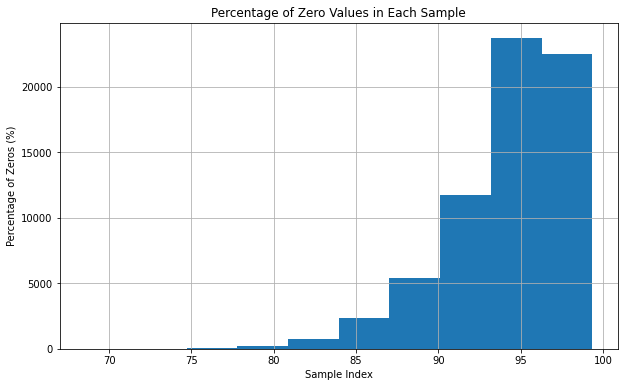

,0
count,66746.000000
mean,94.176583
std,3.540200
min,68.536932
25%,92.400568
50%,95.099432
75%,96.803977
max,99.360795


In [32]:
#Some stats about samples (specifically, the distribution of gene expression values - we don't want too many zeros)
percentage_zeros = X.apply(lambda x: (x == 0).mean() * 100, axis=1)

print(f'Number of observational samples: {obs_data.shape[1]}')
print(f'Number of interventional samples: {int_data.shape[1]}')
print(f'Number of genes: {int_data.shape[0]}')

plt.figure(figsize=(10, 6))
plt.hist(percentage_zeros)
plt.xlabel('Sample Index')
plt.ylabel('Percentage of Zeros (%)')
plt.title('Percentage of Zero Values in Each Sample')
plt.grid(True)
plt.show()


pd.DataFrame(percentage_zeros).describe()

In [ ]:
############Assemble the dataset
order = np.array(range(obs_data.shape[1]))
np.random.shuffle(order)
i = 0
#shuffle obs data columns
backward_data_list = []
unique_names_pert = set()

for sample_id in int_data.columns:
    binary_indicator_perturbation = np.zeros(len(int_data))
    binary_indicator_perturbation[int_metadata.loc[sample_id]['target_indices']] = 1
    #Get a random pre-intervention sample
    i = i % obs_data.shape[1]
    sample_index = order[i]
    obs_sample = obs_data[obs_data.columns[i]].values
    #concat initial node features and perturbation indicator
    diseased = torch.Tensor(obs_sample)
    intervention = torch.Tensor(binary_indicator_perturbation)
    mutations = torch.Tensor(np.zeros(len(diseased)))

        #randomize so I only include a percentage of the mutations for each sample
    perc_to_include = np.random.choice([0.25, 0.50, 0.75, 1], 1).item()
    cosmic_mutations_i = np.random.choice(cosmic_mutations, int(len(cosmic_mutations)* perc_to_include))
    mutations = torch.Tensor(np.zeros(len(diseased)))
    mutations[cosmic_mutations_i] = 1                                                                 ##TODO: CHANGE THIS TO HAVE RANDOM SUBSELECTION

    #post-intervention
    treated = torch.Tensor(int_data[sample_id])

    drug_name = int_metadata.loc[sample_id]['dbid']
    unique_names_pert.add(drug_name)
    data = Data(perturbagen_name = drug_name, diseased = diseased, intervention=intervention, treated = treated, gene_symbols = gene_symbols, mutations = mutations)
    data.num_nodes = number_of_nodes
    backward_data_list.append(data)
    i +=1

print('Samples backward:\t{}\n'.format(len(backward_data_list)))
print('Unique perturbagens:\t{}\n'.format(len(unique_names_pert)))

In [ ]:
backward_data_list[0:3]

In [ ]:
# #Saving datasets
# print('Saving data {} ...\n\n\n'.format(cell_line))
# torch.save(backward_data_list, osp.join(outdir, 'data_backward_{}.pt'.format(cell_line)))
# torch.save(edge_index, osp.join(outdir, 'edge_index_{}.pt'.format(cell_line)))

In [29]:
int_data

,0,1,2,3,4,5,6,7,8,9,...,58952,58953,58954,58955,58956,58957,58958,58959,58960,58961
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
2,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
4,0.0,0.449337,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.217967,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1403,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1404,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1405,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
1406,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [34]:
n_targets = [len(e) for e in int_metadata['target_indices']]

(array([40042.,     0.,     0., 13665.,     0.,     0.,  3629.,     0.,
            0.,  1626.]),
 array([1. , 1.3, 1.6, 1.9, 2.2, 2.5, 2.8, 3.1, 3.4, 3.7, 4. ]),
 <BarContainer object of 10 artists>)

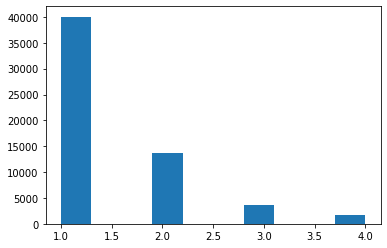

In [35]:
plt.hist(n_targets)